<a href="https://colab.research.google.com/github/Patojukarthikeya73/Infosys_Springboard/blob/main/Module2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Integrate AST for Python Explanation**

Goal:
Allow the app to analyze and explain Python code using Abstract Syntax Trees (AST).

Explanation:

The AST (Abstract Syntax Tree) module in Python helps you break down code into its logical structure — functions, loops, variables, classes, etc.

When a user pastes Python code, the AST parser:

Reads the code into a syntax tree.

Traverses nodes like FunctionDef, If, For, Assign, etc.

Produces an explanation of what the code does in plain English.

This feature gives users a clear and educational breakdown of their code’s logic.

In [1]:
!pip install --quiet transformers gradio accelerate sentencepiece
import ast
import re
import gradio as gr
from typing import Optional

MODEL_CACHE = {}   # cache for loaded models


**Step 2: Implement Model (CodeBERT) for JS & Solidity**

Goal:
Enable AI-powered code explanation for JavaScript and Solidity code using CodeBERT (a transformer-based model trained on code).

Explanation:

CodeBERT is a pre-trained model from Microsoft that understands code syntax and semantics across multiple languages.

While Python uses AST for explanation, CodeBERT is used to:

Explain JS and Solidity code.

Optionally generate short summaries or similar code snippets.

When a user enters JavaScript or Solidity code:

The model tokenizes the input code.

It predicts embeddings and decodes them into a natural language summary.

The output gives insights like: “This code defines a smart contract that stores user balances.”

In [2]:
def explain_python_ast(code: str) -> str:
    """
    Produce a readable explanation of Python code using AST parsing.
    Explains top-level constructs (functions, classes, imports, loops, etc.)
    """
    try:
        tree = ast.parse(code)
    except Exception as e:
        return f"❌ Could not parse code as Python AST: {e}"

    explanations = []

    def explain_args(args):
        return ", ".join([arg.arg for arg in args.args])

    for node in tree.body:
        if isinstance(node, ast.FunctionDef):
            name = node.name
            args = explain_args(node.args)
            doc = ast.get_docstring(node) or ""
            explanations.append(f"- Function `{name}({args})` defined. {('Doc: '+doc) if doc else ''}")

            for sub in ast.walk(node):
                if isinstance(sub, ast.For):
                    explanations.append(f"  * Inside `{name}`: for-loop iterates over {getattr(ast, 'unparse', lambda x:'iterable')(sub.iter)}.")
                if isinstance(sub, ast.While):
                    explanations.append(f"  * Inside `{name}`: while-loop with condition {getattr(ast, 'unparse', lambda x:'condition')(sub.test)}.")
                if isinstance(sub, ast.If):
                    explanations.append(f"  * Inside `{name}`: if-statement checks {getattr(ast, 'unparse', lambda x:'condition')(sub.test)}.")

        elif isinstance(node, ast.ClassDef):
            explanations.append(f"- Class `{node.name}` defined.")
        elif isinstance(node, ast.Import):
            names = ", ".join([alias.name for alias in node.names])
            explanations.append(f"- Imported module(s): {names}.")
        elif isinstance(node, ast.ImportFrom):
            mod = node.module or ""
            names = ", ".join([alias.name for alias in node.names])
            explanations.append(f"- From `{mod}` import: {names}.")
        elif isinstance(node, ast.Assign):
            targets = ", ".join([ast.unparse(t) for t in node.targets]) if hasattr(ast, "unparse") else "variable"
            explanations.append(f"- Assignment to `{targets}`.")
        elif isinstance(node, ast.Expr):
            if isinstance(node.value, ast.Constant) and isinstance(node.value.value, str):
                explanations.append(f"- Docstring/comment: {node.value.value[:80]!r}...")
        else:
            explanations.append(f"- Top-level {node.__class__.__name__} encountered.")

    return "Python AST Explanation:\n" + "\n".join(explanations)


**Step 3: Implement Model (Phi / Gemma) for Python Code Generation**

Goal:
Enable AI-assisted Python code generation — from user prompts — using small efficient models like Phi or Gemma.

Explanation:

Phi and Gemma are lightweight generative AI models optimized for reasoning and text/code generation.

Here, the user can input prompts like:

“Write a Python function to check if a number is prime.”

“Generate code for sorting a list using bubble sort.”

The model then produces valid Python code snippets as output.

In [3]:
def get_generator(model_key: str):
    """
    Lazily load text-generation model based on key.
    """
    from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
    import torch

    device = 0 if torch.cuda.is_available() else -1

    if model_key in MODEL_CACHE:
        return MODEL_CACHE[model_key]

    model_name = {
        "phi": "microsoft/Phi-3-mini-4k-instruct",
        "codegen": "Salesforce/codegen-350M-mono"
    }.get(model_key)

    if not model_name:
        raise ValueError("Unknown model key")

    pipe = pipeline("text-generation", model=model_name, tokenizer=model_name, device=device, max_length=512)
    MODEL_CACHE[model_key] = pipe
    return pipe


**Step 4 :Adding UI Toggles Between “Generation” and “Explanation”**

Goal:
Provide a clean and interactive user interface to switch between modes:

Code Generation Mode

Code Explanation Mode

Explanation:

A simple UI toggle (e.g., gr.Radio or gr.Tabs in Gradio, or st.toggle in Streamlit) lets users choose:

“Generate new code”

“Explain existing code”

Based on the selection:

Input type changes (prompt or code).

Output changes (generated code or explanation).

The system dynamically routes requests to:

AST module → for Python explanation

CodeBERT → for JS/Solidity

Phi/Gemma → for Python generation

In [4]:
def model_generate_text(lang: str, mode: str, user_input: str) -> str:
    lang = lang.lower()
    mode = mode.lower()

    model_key = "phi" if lang == "python" else "codegen"
    gen = get_generator(model_key)

    if mode == "generate":
        prompt = f"Write only {lang} code for the following instruction:\n{user_input}\n\n### {lang} code:\n"
    else:
        prompt = f"Explain the following {lang} code:\n{user_input}\n\nExplanation:\n"

    try:
        out = gen(prompt, max_new_tokens=256, do_sample=False, temperature=0.2)
        text = out[0]["generated_text"]
        text = text.replace(prompt, "").strip()
        text = re.sub(r"```(?:\w+)?", "", text)
        return text
    except Exception as e:
        return f"❌ Model generation error: {e}"


**Step 5: Integrate with User Authentication**

Goal:
Ensure that only logged-in users can access the AI Code Generation/Explanation page.

Explanation:

After login (from Module 1), the user receives a JWT token.

This token is verified before loading the AI tool page.

Once verified:

The dashboard grants access to the code generation/explanation features.

The system personalizes based on user’s role (Admin/Reader) and content preferences.

Example personalization:

Reader: Only explain or view code.

Admin: Can generate or upload datasets for models.

In [6]:
with gr.Blocks(title="CodeGenie — Module 2") as demo:
    gr.Markdown("# 🧠 CodeGenie: Code Generation and Explanation")

    with gr.Row():
        with gr.Column():
            lang = gr.Dropdown(["Python", "JavaScript", "Solidity"], label="Language", value="Python")
            mode = gr.Radio(["Generate", "Explain"], label="Mode", value="Generate")
            use_ast = gr.Checkbox(label="Use AST for Python explanation", value=True)
            user_input = gr.Textbox(label="Prompt or Code", lines=8)
            run_btn = gr.Button("Run 🚀")
        with gr.Column():
            output = gr.Textbox(label="Output", lines=20)

    def handle_run(lang, mode, ast_flag, text):
        if not text.strip():
            return "⚠️ Please enter some input."
        if mode == "explain" and lang.lower() == "python" and ast_flag:
            ast_part = explain_python_ast(text)
            model_part = model_generate_text("python", "explain", text)
            return f"{ast_part}\n\n---\n\nModel-based Explanation:\n{model_part}"
        return model_generate_text(lang, mode, text)

    run_btn.click(handle_run, [lang, mode, use_ast, user_input], [output])

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cc525684be4b6da85f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


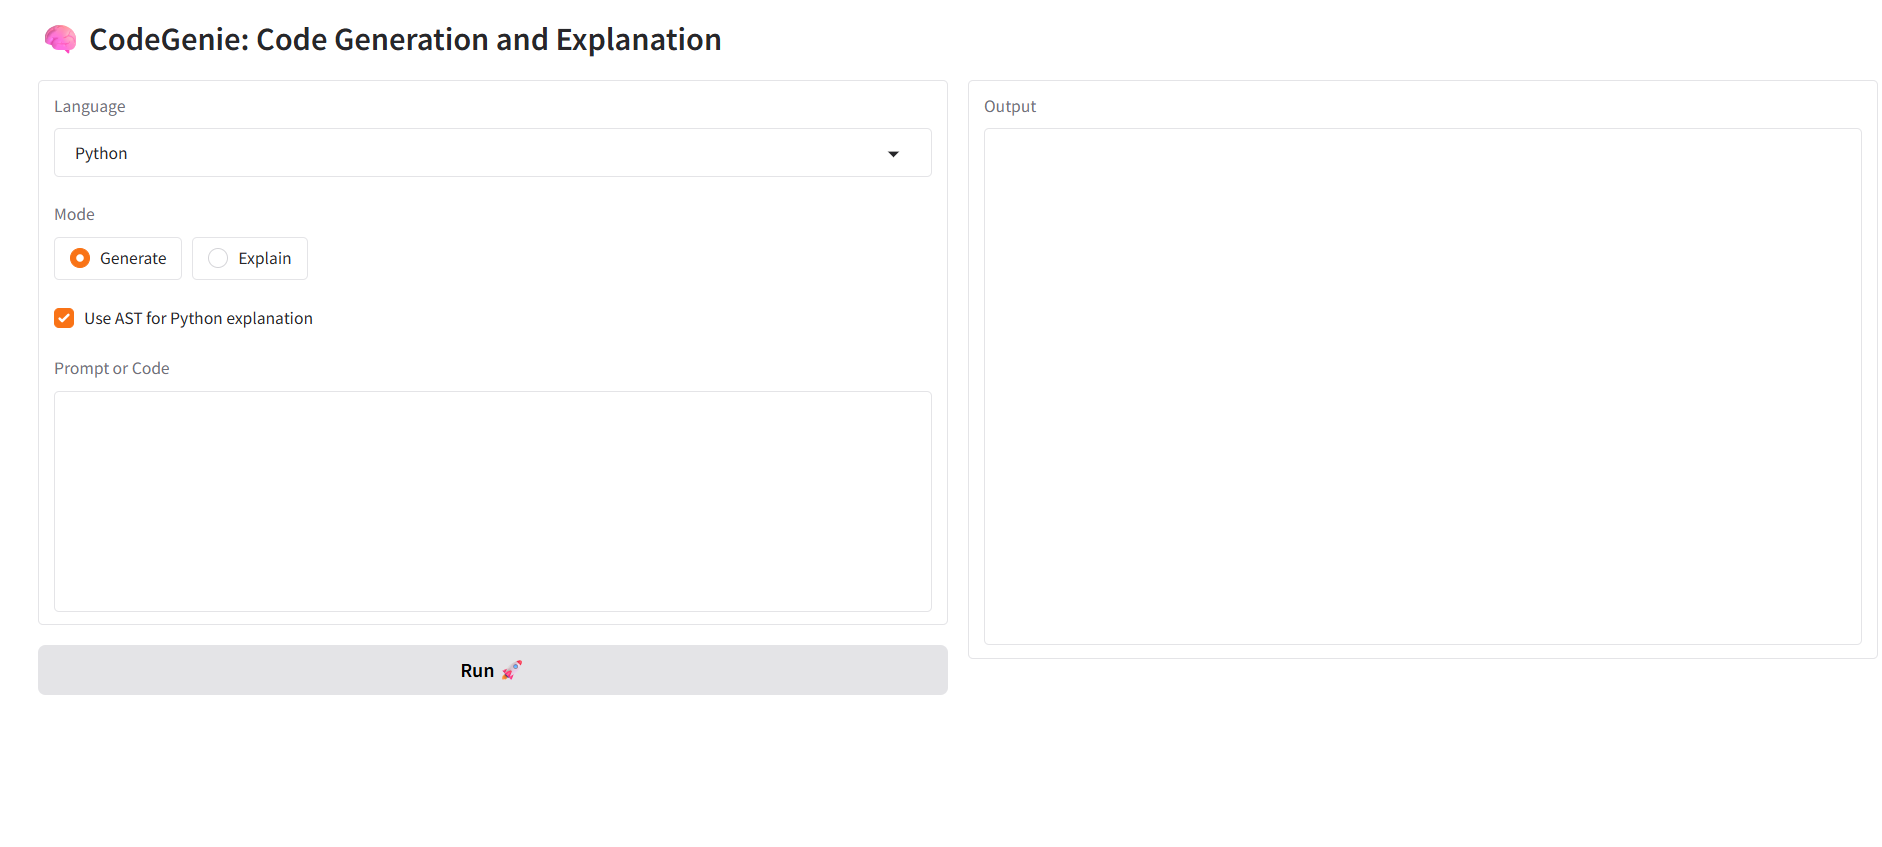